In [1]:
import numpy as np
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
from choseg import inference, utils
from choseg.metrics import choroid_measurements, chor_utils
model_path = os.path.join(sys.path[-1], "choseg\weights\model_weights.pth")

C:\Users\s1522100\Documents\PhD Work\Python Scripts\Github\deepgpet\choseg\inference.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Load model and images

In [2]:
deepgpet = inference.InferenceModel(model_path=model_path, threshold=0.5) # Instantiate model, with desired threshold 

In [3]:
path_list = list(Path(sys.path[-1]).rglob("image*.png"))
img_list = [utils.load_img(path) for path in path_list]

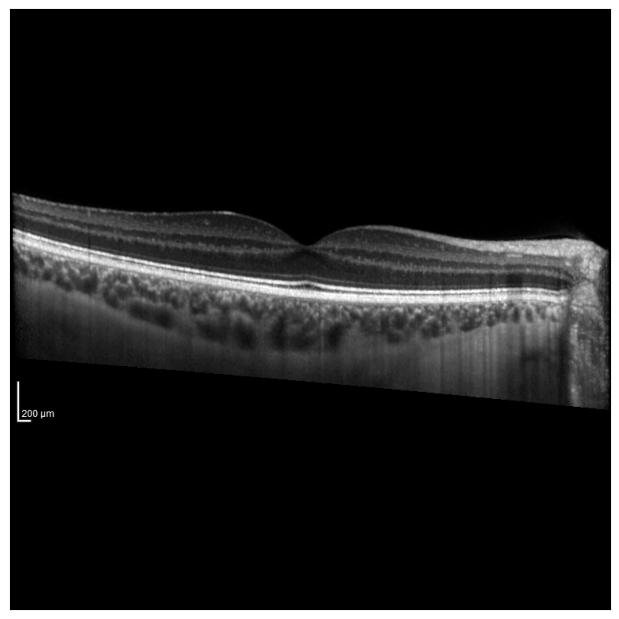

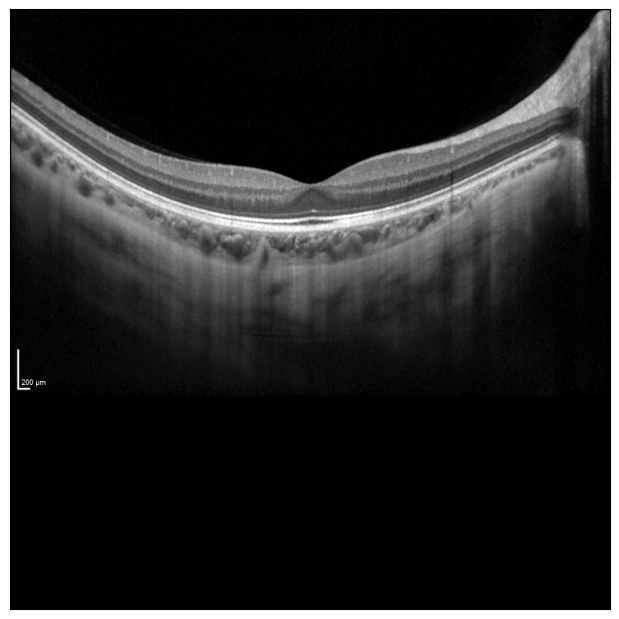

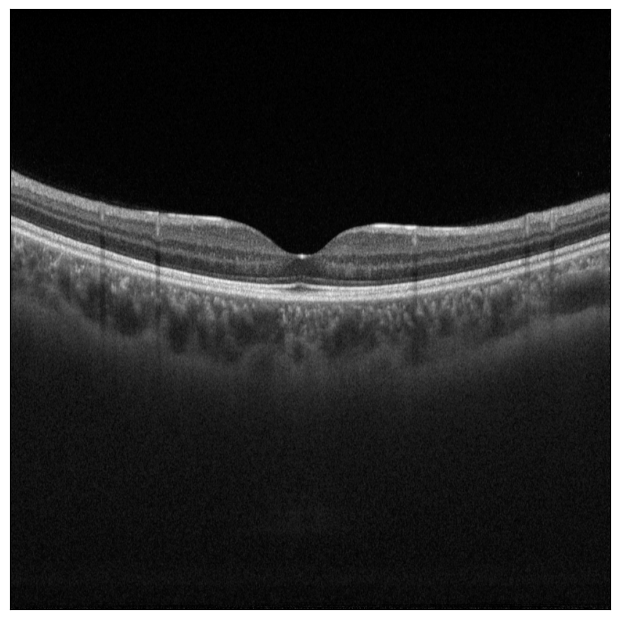

In [4]:
utils.plot_img(img_list[0])
utils.plot_img(img_list[1])
utils.plot_img(img_list[2])

# Segment images and extract traces

In [5]:
# Inference from a list of image arrays
preds = deepgpet.predict_list(img_list)

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
traces = [utils.extract_bounds(p) for p in preds]

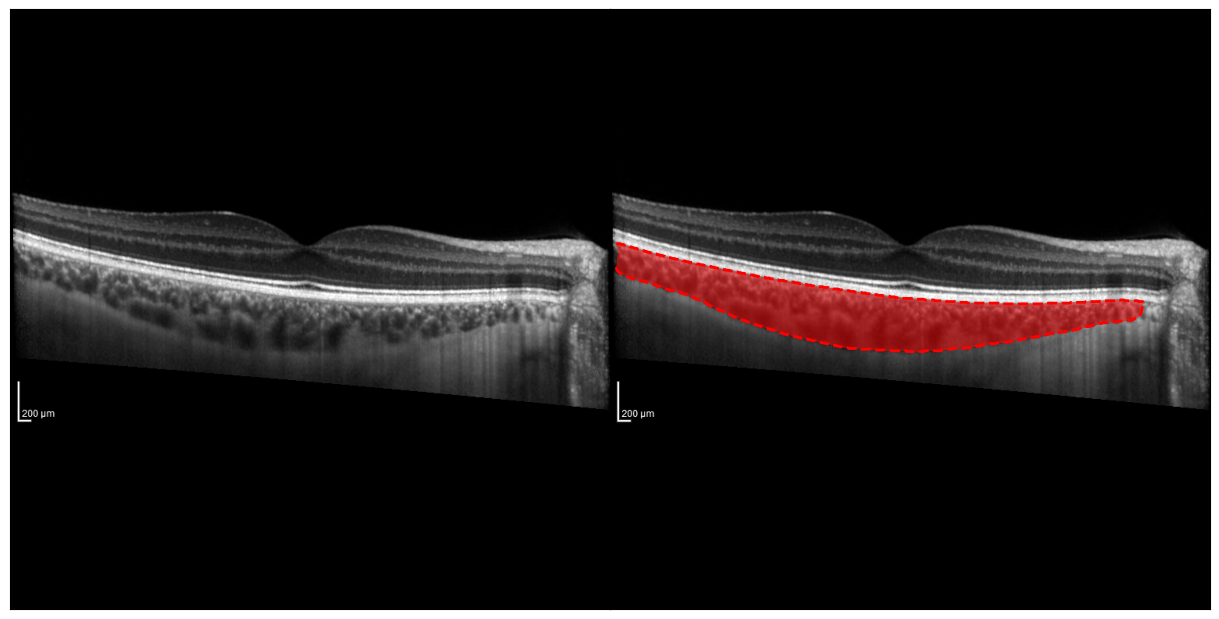

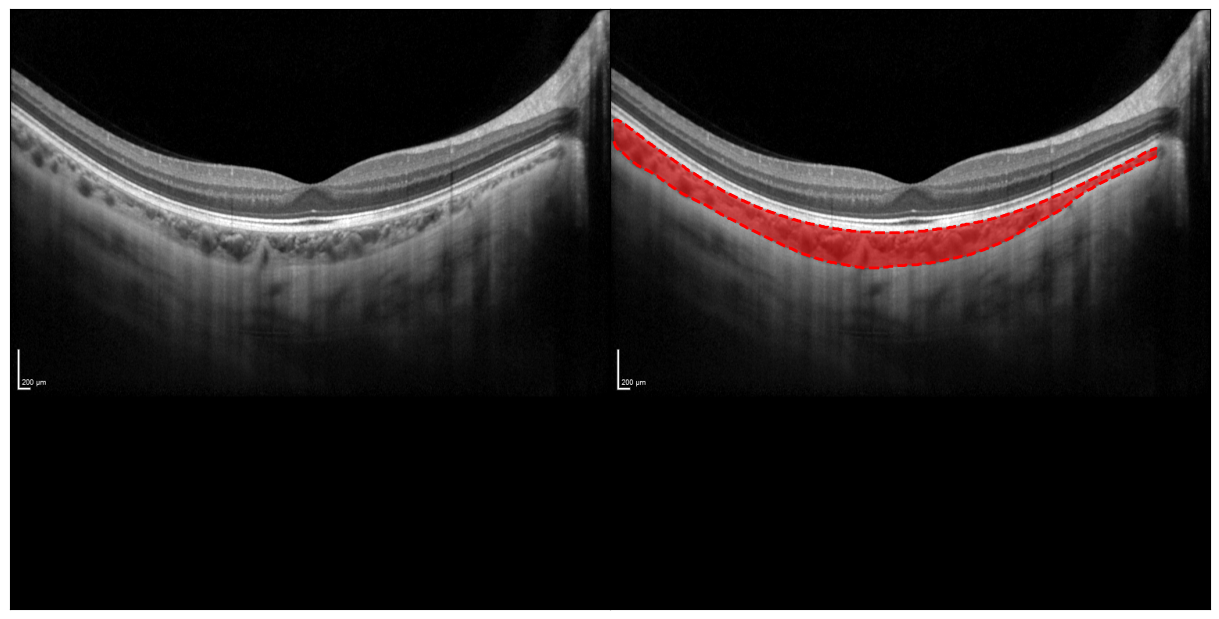

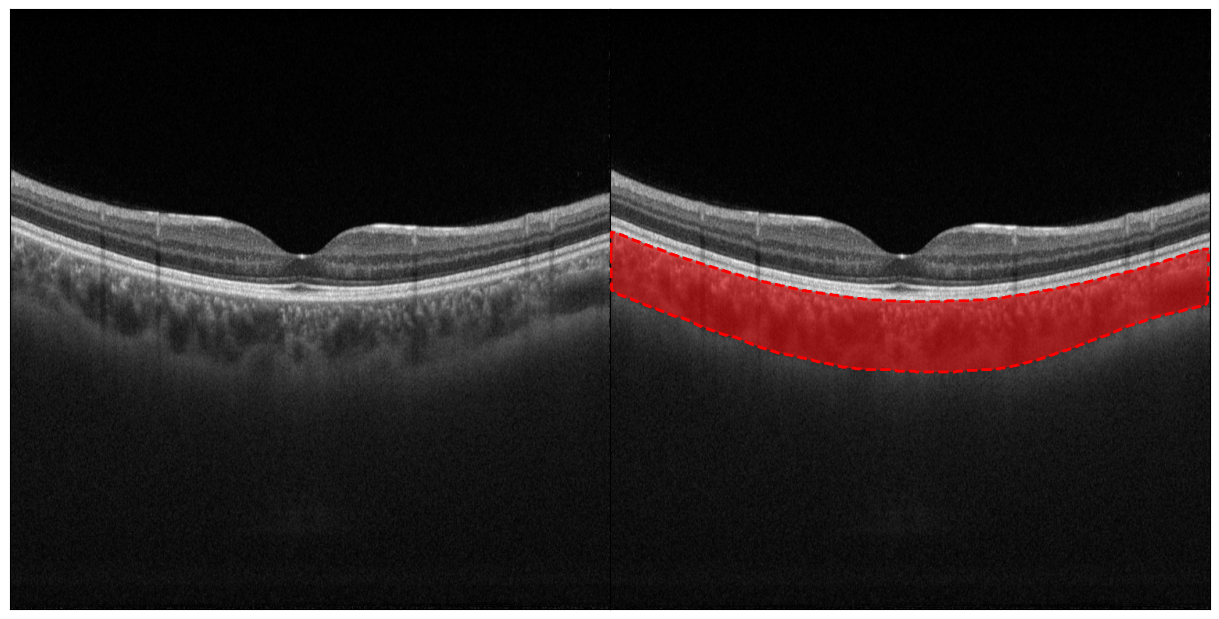

In [7]:
for img, seg, tr in zip(img_list, preds, traces):
    utils.plot_img(img, traces=tr, cmap=utils.generate_imgmask(seg), sidebyside=True)

# Detect fovea coordinates for derived choroid measurements

In [8]:
# for i,img in enumerate(img_list):
#     # It's only important to get the column index of the fovea, the row doesn't matter so much
#     chor_utils.select_pixels(img, scale=800, save_path="example_data", fname=f"fovea_{i+1}", cmap=None)()

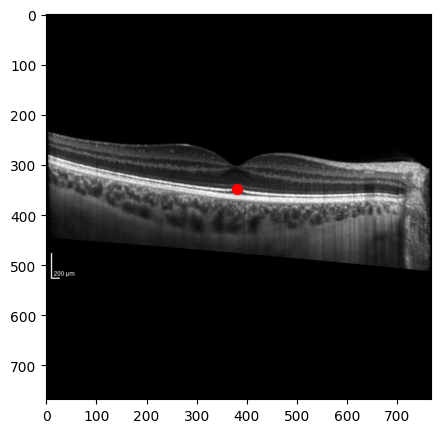

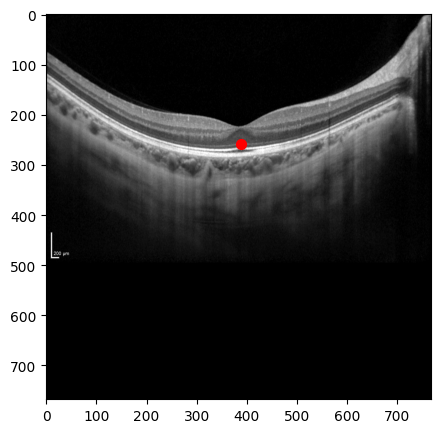

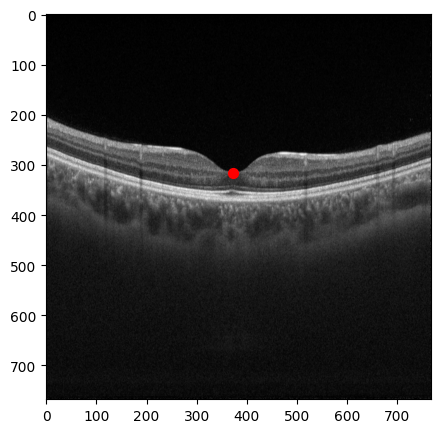

In [9]:
foveas = []
for i, img in enumerate(img_list):
    fov = pd.read_csv(os.path.join("example_data", f"fovea_{i+1}.csv")).values[0]
    foveas.append(fov)
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.imshow(img, cmap="gray")
    ax.scatter(fov[0], fov[1], s=50, color="r")

---
# Derived choroid measurements on single OCT B-scan

## Measure choroid thickness

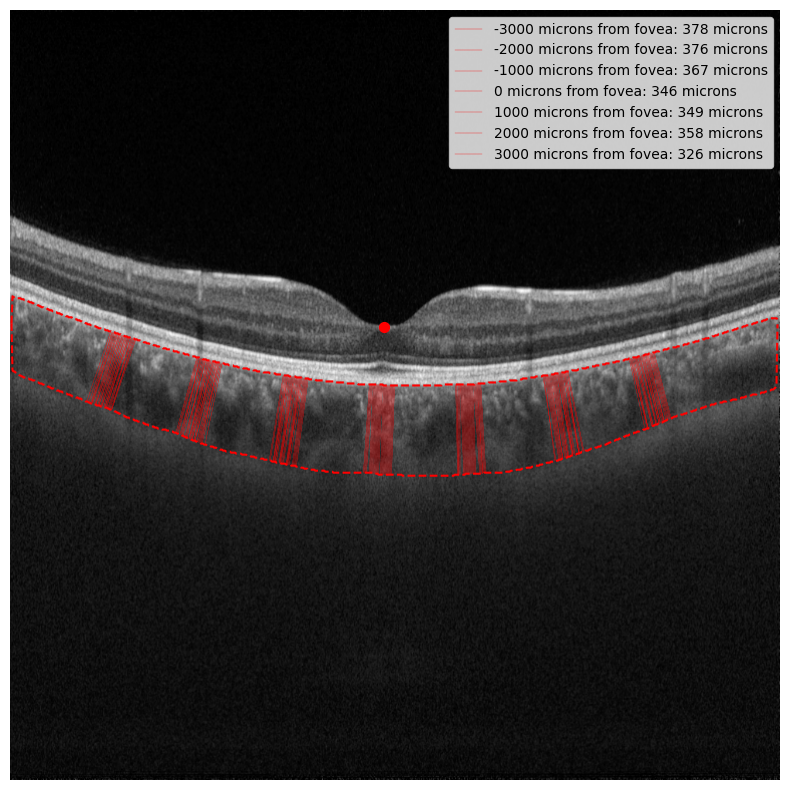

In [10]:
idx = 2
N_measures = 7
N_avgs = 25

# This function returns thickness and area
CT, CA, lines, distances = choroid_measurements.compute_choroid_thickness_area(
                                                    traces[idx],                   # Can input trace or mask
                                                    fovea=foveas[idx], 
                                                    scale=(11.49,3.87,None),       # This is microns-per-pixel in x and z directions. 
                                                    macula_rum=3000,               # Micron radius either side of fovea to measure 
                                                    N_measures=N_measures,         # Number of thickness measurements distributed across choroid
                                                    N_avgs=N_avgs,                 # How many adjecent thicknesses to average at each location to enforce robustness
                                                    offset=15,               
                                                    return_lines = True,           # If true, return information to plot the point-source thickness measurements 
                                                    return_distances = True,       # Returns the distance from the fovea at which each thickness measurement was made
                                                    )

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img_list[idx], cmap="gray")
ax.scatter(foveas[idx][0], foveas[idx][1], s=50, color="r", label="_nolegend_")
for i in range(2):
    ax.plot(traces[idx][i][:,0],traces[idx][i][:,1], c="r", linestyle="--", label="_nolegend_")
for i in range(N_measures):
    for j in range(N_avgs+1):
        label = "_nolegend_"
        if j == 0:
            label = f"{distances[i]} microns from fovea: {CT[i][0]} microns"
        ax.plot(lines[i][j][:,0], lines[i][j][:,1], c="r", linewidth=0.25, label=label)
ax.legend()#bbox_to_anchor=(1.05, 1.0))
ax.set_axis_off()

## Measure choroid area

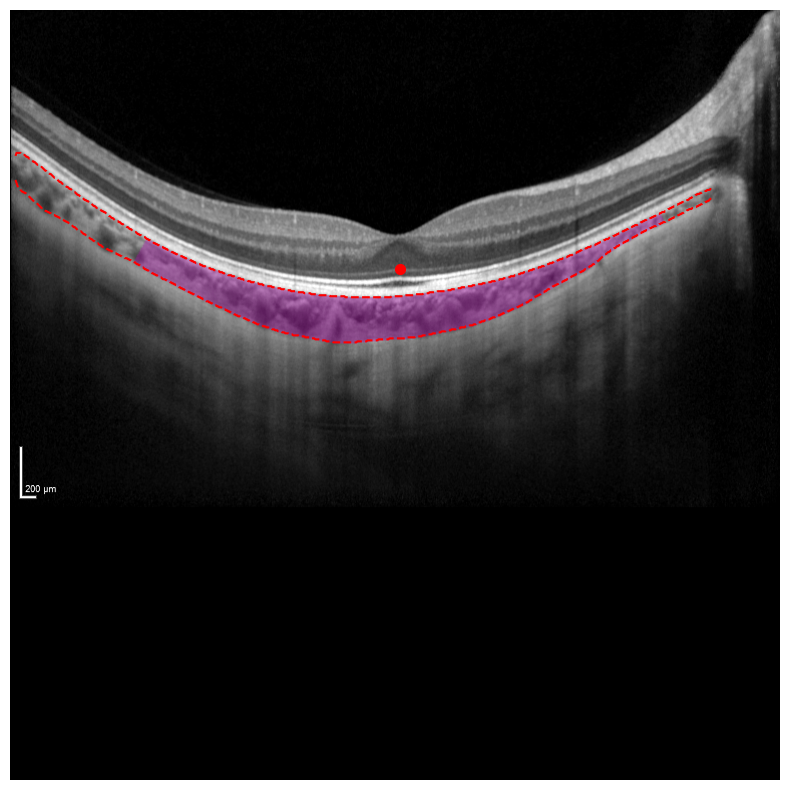

In [11]:
idx = 1

# This function returns thickness and area
CT, CA, lines = choroid_measurements.compute_choroid_crosssectionarea(
                                                    preds[idx],                   # Can input trace or mask
                                                    fovea=foveas[idx], 
                                                    macula_rum=3000,
                                                    scale=(11.49,3.87,None),       # This is microns-per-pixel in x and z directions. 
                                                    return_lines = True,           # If true, return information on the choroidal pixels used to compute area
                                                    )

keep_pixel, (x_range, y_range), (left_x, right_x) = lines
# keep_pixels are the pixels contained within the ROI for measuring CA
# (x_range, y_range) are the full range of x and y values which define the smallest rectangle which overlaps the ROI
# (left_x, right_x) are lines perpendicular to the upper choroid boundary at the left and right extremes of ROI

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img_list[idx], cmap="gray")
ax.scatter(foveas[idx][0], foveas[idx][1], s=50, color="r", label="_nolegend_")
for i in range(2):
    ax.plot(traces[idx][i][:,0],traces[idx][i][:,1], c="r", linestyle="--", label="_nolegend_")
    
# Plot the area
for i,x in enumerate(x_range):
    which_pixels = keep_pixel[keep_pixel[:,0] == x, 1]
    if which_pixels.shape[0] > 0:
            ax.fill_between(np.array([x-0.25, x+0.25]), 
                            np.array([which_pixels.min()-0.25, which_pixels.min()+0.25]), 
                        np.array([which_pixels.max()-0.25, which_pixels.max()+0.25]), color="m", alpha=0.15,label="_nolegend_")

#ax.legend()#bbox_to_anchor=(1.05, 1.0))
ax.set_axis_off()